In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_reviews.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9790 entries, 0 to 9789
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         9790 non-null   int64  
 1   restaurant_id     9790 non-null   int64  
 2   date              9790 non-null   object 
 3   rating            9790 non-null   int64  
 4   review_text       9790 non-null   object 
 5   monthly_sales     9790 non-null   float64
 6   complaints_count  9790 non-null   float64
 7   avg_rating        9790 non-null   float64
 8   staff_turnover    9790 non-null   float64
 9   risk_label        9790 non-null   int64  
 10  month             9790 non-null   int64  
 11  weekday           9790 non-null   int64  
 12  sentiment         9790 non-null   float64
 13  review_length     9790 non-null   float64
dtypes: float64(6), int64(6), object(2)
memory usage: 1.0+ MB


,review_id,restaurant_id,date,rating,review_text,monthly_sales,complaints_count,avg_rating,staff_turnover,risk_label,month,weekday,sentiment,review_length
0,1,99,2025-05-01,5,should doctor paper land third realize rich ea...,0.102962,0.625640,-0.435796,-1.634494,0,5,3,0.292192,0.060847
1,2,155,2025-05-28,1,product water after already face effort possib...,1.128980,0.552458,-0.276476,1.344131,0,5,2,0.589006,0.263258
2,3,174,2025-08-30,2,tree play my likely any model smile address of...,0.251855,0.040186,1.635370,-0.232788,0,8,5,-0.038543,1.680135
3,4,16,2024-10-17,4,almost cell sell away civil task.,0.696839,0.918366,-0.475626,1.344131,0,10,3,-0.428641,-1.558440
4,5,119,2025-04-26,4,section space state investment know laugh hear...,1.582094,-1.130720,0.798938,0.643278,0,4,5,-0.089426,0.870491


In [ ]:
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler

df['sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))

feature_columns = ['monthly_sales', 'complaints_count', 'avg_rating', 'staff_turnover', 'review_length', 'sentiment']
X = df[feature_columns]
y = df['risk_label']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=feature_columns)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [ ]:
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:22:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1675
           1       1.00      1.00      1.00       283

    accuracy                           1.00      1958
   macro avg       1.00      1.00      1.00      1958
weighted avg       1.00      1.00      1.00      1958

ROC-AUC: 1.000


In [ ]:
#risk label
y_pred = model.predict(X_test)
print(y_pred)

#prob of higher risk
y_proba = model.predict_proba(X_test)[:,1]
print(y_proba)

[1 0 1 ... 1 0 0]
[9.9942422e-01 5.7313435e-05 9.9851543e-01 ... 9.9943978e-01 5.7313435e-05
 1.2523154e-04]


In [ ]:
df['risk_probability'] = model.predict_proba(X)[:,1]
restaurant_risk = df.groupby('restaurant_id')['risk_probability'].mean().reset_index()
restaurant_risk = restaurant_risk.sort_values('risk_probability', ascending=False)

In [ ]:
#this is the list of top 10 rest. at high risk.
top_high_risk = restaurant_risk.head(10)
print(top_high_risk)

     restaurant_id  risk_probability
188            189          0.999440
64              65          0.999440
170            171          0.999440
138            139          0.999440
113            114          0.999440
194            195          0.999440
130            131          0.999440
68              69          0.999424
25              26          0.999424
175            176          0.999424


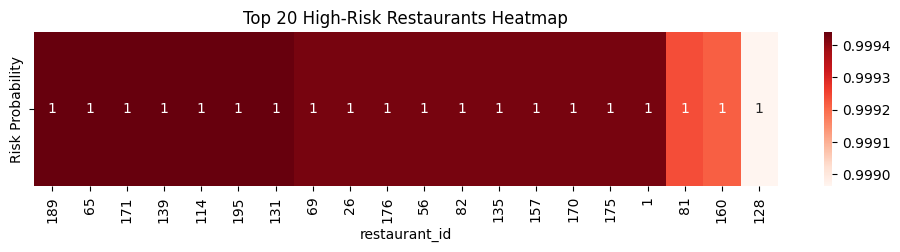

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_restaurants = restaurant_risk.head(20)

heatmap_data = top_restaurants.set_index('restaurant_id').T  # transpose so restaurants are columns

plt.figure(figsize=(12,2))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', cbar=True)
plt.yticks([0.5], ['Risk Probability'])  # label for the row
plt.xticks(rotation=90)
plt.title("Top 20 High-Risk Restaurants Heatmap")
plt.show()


In [ ]:
!pip install shap


In [ ]:
import shap
import matplotlib.pyplot as plt


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


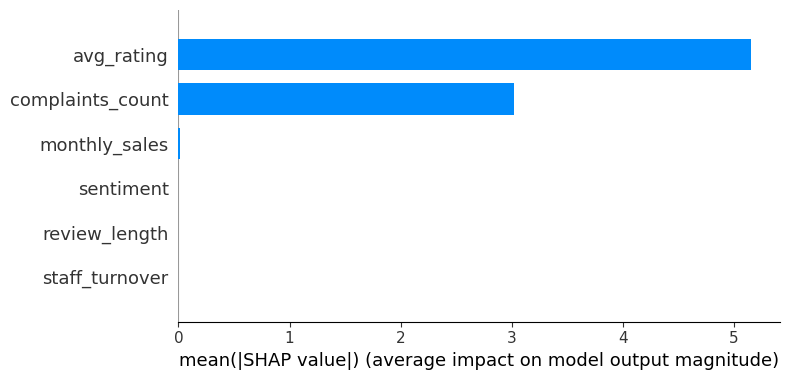

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


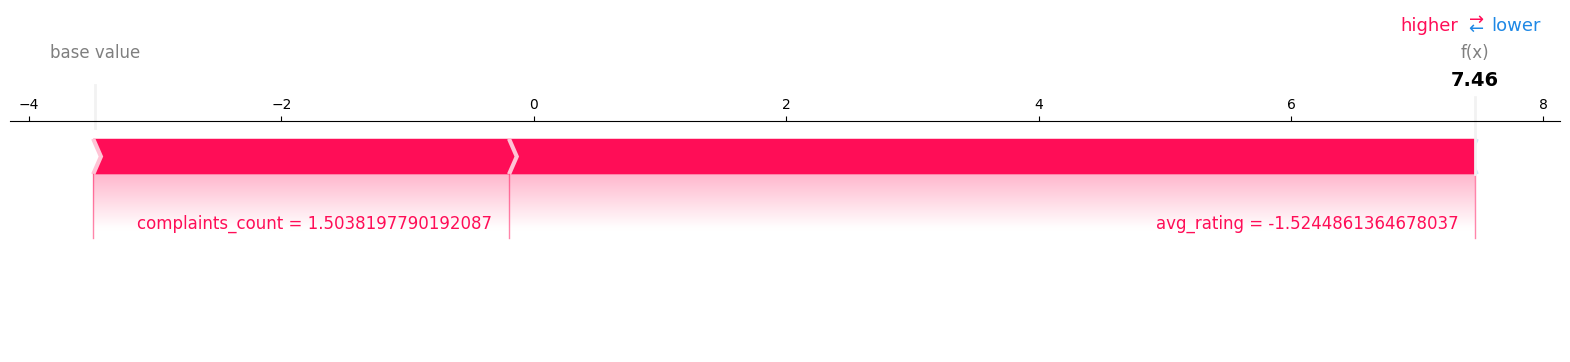

In [ ]:
restaurant_idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[restaurant_idx,:],
    X_test.iloc[restaurant_idx,:],
    matplotlib=True
)


Restaurant ID: 26


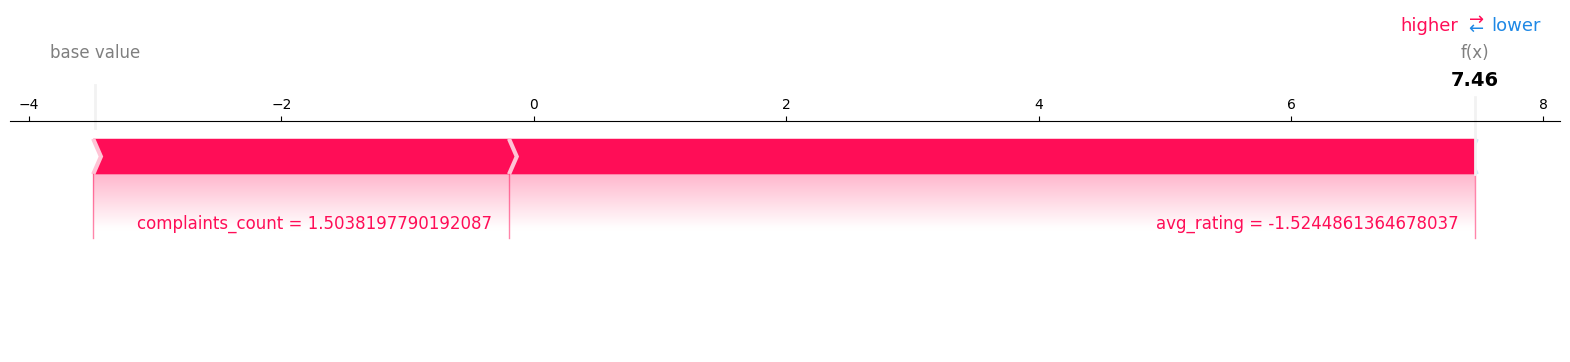

Restaurant ID: 175


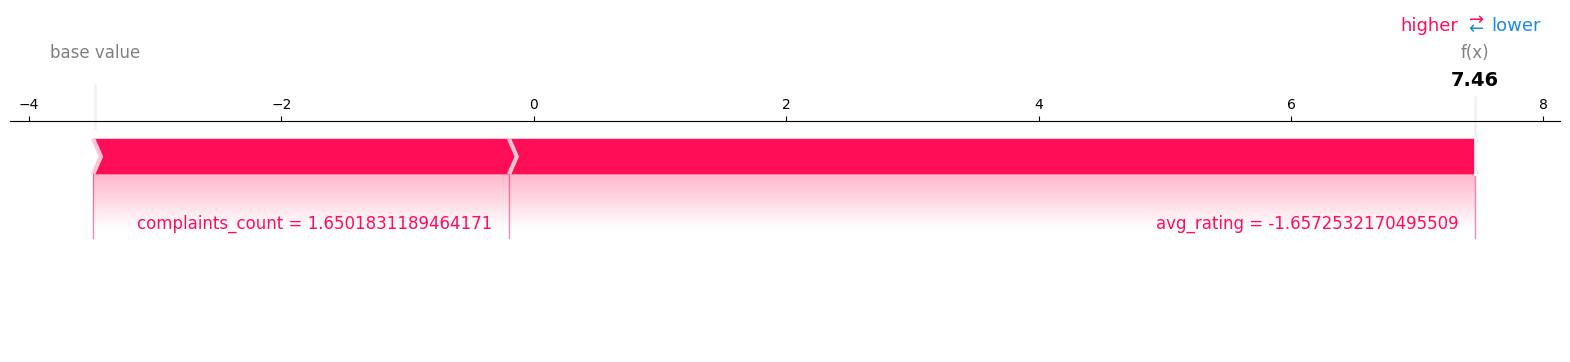

In [ ]:
for idx in [0, 5]:
    print(f"Restaurant ID: {df.iloc[X_test.index[idx]]['restaurant_id']}")
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx,:],
        X_test.iloc[idx,:],
        matplotlib=True
    )


In [ ]:
import joblib

joblib.dump(model, "restaurant_risk_xgb.pkl")


['restaurant_risk_xgb.pkl']

In [ ]:
#making this just for evaluation and comparison btw all 3 models
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import json

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

metrics = {
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
}

with open("metrics_XGBoost.json", "w") as f:
    json.dump(metrics, f)
